Базовое совмещение

In [ ]:
import numpy as np
from scipy.fft import fft2, ifft2
from skimage.io import imread
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


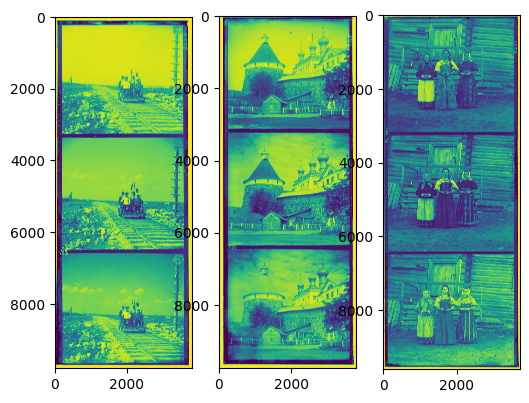

In [118]:
image_0 = imread('10.png')
image_1 = imread('11.png')
image_2 = imread('14.png')
fig, ax = plt.subplots(1, 3, figsize=(6, 5))
ax[0].imshow(image_0)
ax[1].imshow(image_1)
ax[2].imshow(image_2)

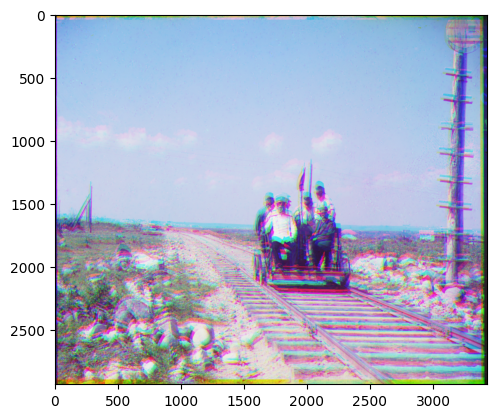

In [ ]:
def quick_preprocessing(image, padding=.05):
    rgb = np.dstack(np.array_split(image[:image.shape[0]//3*3], 3, axis=0)[:][:image.shape[0] // 3][::-1])
    rgb = rgb[int(padding*rgb.shape[0]): int(-padding*rgb.shape[0]), int(padding*rgb.shape[1]): int(-padding*rgb.shape[1]), :]
    return rgb

metrics = {
    'mse': lambda x, y: np.sum((x-y)**2),
    'cross_correlation': lambda x, y: np.sum(x * y) / np.sqrt(np.sum(x**2) * np.sum(y**2))
}

def calibrate_image(image):
    shift_best = np.array([(0, 0), (0, 0), (0, 0)])
    for scale in [1/2**i for i in range(np.log2(image.shape[1] / 500).astype(int), -1, -1)]:
        image_shifted = np.pad(cv2.resize(image, None, fx=scale, fy=scale), ((30,30), (30,30), (0,0)))
        for i in range(image_shifted.shape[-1]):
            image_shifted[:,:,i] = np.roll(image_shifted[:,:,i], shift_best[i], (0, 1))
        shift_scale_best = np.array([(0, 0), (0, 0), (0, 0)])
        shift_scale_metric_best = np.inf
        for i in [0, 1]:
            for shift_x in range(-30, 30):
                for shift_y in range(-30, 30):
                    shifted_channel = np.roll(image_shifted[:,:,i], (shift_x, shift_y), (0, 1))
                    shift_metric = metrics['mse'](
                        image_shifted[:,:,2],
                        shifted_channel,
                    )
                    if shift_metric < shift_scale_metric_best:
                        shift_scale_metric_best = shift_metric
                        shift_scale_best[i] = (shift_x, shift_y)
                        image_shifted[:,:,i] = shifted_channel

        shift_scale_best -= shift_scale_best.mean(axis=0).astype(int)
        shift_best += shift_scale_best * int(1/scale)

    image_shifted = image.copy()
    for i in range(image.shape[-1]):
        image_shifted[:,:,i] = np.roll(image_shifted[:,:,i], shift_best[i], (0, 1))

    return image_shifted

# plt.imshow(quick_preprocessing(image_0)
plt.imshow(calibrate_image(quick_preprocessing(image_0)))


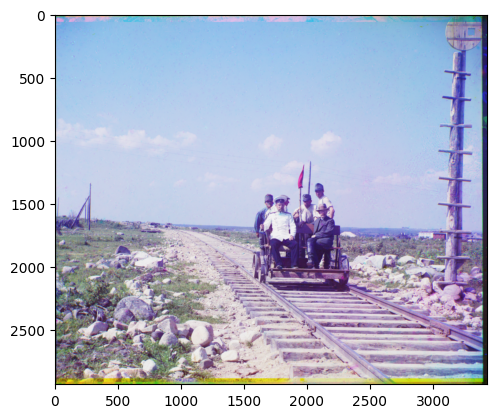

In [ ]:
def quick_preprocessing(image, padding=.05):
    rgb = np.dstack(np.array_split(image[:image.shape[0]//3*3], 3, axis=0)[:][:image.shape[0] // 3][::-1])
    rgb = rgb[int(padding*rgb.shape[0]): int(-padding*rgb.shape[0]), int(padding*rgb.shape[1]): int(-padding*rgb.shape[1]), :]
    return rgb

def calibrate_image_improved(image):
    r_to_g_channel_shift = ifft2(fft2(image[:,:,0]) * np.conj(fft2(image[:,:,1]))).real
    b_to_g_channel_shift = ifft2(fft2(image[:,:,2]) * np.conj(fft2(image[:,:,1]))).real


    r_shift = np.array(np.unravel_index(np.argmax(r_to_g_channel_shift), image.shape[:2]))
    b_shift = np.array(np.unravel_index(np.argmax(b_to_g_channel_shift), image.shape[:2]))
    wrap_shift = lambda x: (x + np.array(image.shape)[:2] // 2) % image.shape[:2] - np.array(image.shape)[:2] // 2

    shift = np.array([wrap_shift(r_shift), (0, 0), wrap_shift(b_shift)])
    shift -= shift.mean(axis=0).astype(int)

    image_shifted = image.copy()
    image_shifted[:,:,0] = np.roll(image_shifted[:,:,0], -shift[0], (0, 1))
    image_shifted[:,:,1] = np.roll(image_shifted[:,:,1], -shift[1], (0, 1))
    image_shifted[:,:,2] = np.roll(image_shifted[:,:,2], -shift[2], (0, 1))

    return image_shifted

# plt.imshow(quick_preprocessing(image_0))
plt.imshow(calibrate_image_improved(quick_preprocessing(image_0)))